<a href="https://colab.research.google.com/github/Thunyawat2543/football/blob/main/mini_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMPORT**

In [1]:
import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
import sqlite3
import seaborn as sns
from sklearn.linear_model import LinearRegression

**เลือกไฟล์ที่จะนำมาวิเคราห์**

In [2]:
from google.colab import files

uploaded = files.upload()


Saving database.sqlite.zip to database.sqlite.zip


**แตกไฟล์**

In [3]:
!unzip database.sqlite.zip

Archive:  database.sqlite.zip
  inflating: database.sqlite         


**Clean data**

In [52]:
# 1) สร้างการเชื่อมต่อ (Connection) กับไฟล์ database.sqlite
conn = sqlite3.connect('database.sqlite')

# 2) ตรวจสอบว่ามีตารางอะไรบ้างในฐานข้อมูล
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
print("All tables in DB:")
print(tables)

# 3) อ่านข้อมูลจากตาราง
df = pd.read_sql_query("SELECT * FROM Player_Attributes", conn)
print("\nข้อมูลตัวอย่างจาก Player_Attributes:")
print(df.head())

# ขั้นตอนการทำความสะอาดข้อมูล
# 4) ตรวจสอบ Missing Values
print("\nMissing Values (ก่อนการจัดการ):")
print(df.isnull().sum())

# 5) ลบข้อมูลที่ซ้ำ (ถ้ามี)
df.drop_duplicates(inplace=True)

# 6) เติม Missing Values
numeric_cols = df.select_dtypes(include=[np.number]).columns
categorical_cols = df.select_dtypes(include=['object']).columns

df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode().iloc[0])

# 7) ตรวจสอบข้อมูลหลังการ Clean
print("\nMissing Values (หลังการจัดการ):")
print(df.isnull().sum())



All tables in DB:
                name
0    sqlite_sequence
1  Player_Attributes
2             Player
3              Match
4             League
5            Country
6               Team
7    Team_Attributes

ข้อมูลตัวอย่างจาก Player_Attributes:
   id  player_fifa_api_id  player_api_id                 date  overall_rating  \
0   1              218353         505942  2016-02-18 00:00:00            67.0   
1   2              218353         505942  2015-11-19 00:00:00            67.0   
2   3              218353         505942  2015-09-21 00:00:00            62.0   
3   4              218353         505942  2015-03-20 00:00:00            61.0   
4   5              218353         505942  2007-02-22 00:00:00            61.0   

   potential preferred_foot attacking_work_rate defensive_work_rate  crossing  \
0       71.0          right              medium              medium      49.0   
1       71.0          right              medium              medium      49.0   
2       66.0          rig

**LOAD DATA**

In [53]:
df_player = pd.read_sql_query("SELECT * FROM Player", conn)
df_team = pd.read_sql_query("SELECT * FROM Team", conn)
df_match = pd.read_sql_query("SELECT * FROM Match", conn)
df_player_attr = pd.read_sql_query("SELECT * FROM Player_Attributes", conn)
df_team_attr = pd.read_sql_query("SELECT * FROM Team_Attributes", conn)
df_league = pd.read_sql_query("SELECT * FROM League", conn)

**HEAD** DATA

In [54]:
df_player.head()

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154


In [55]:
print(df_player.head())
print(df_match.head())

   id  player_api_id         player_name  player_fifa_api_id  \
0   1         505942  Aaron Appindangoye              218353   
1   2         155782     Aaron Cresswell              189615   
2   3         162549         Aaron Doran              186170   
3   4          30572       Aaron Galindo              140161   
4   5          23780        Aaron Hughes               17725   

              birthday  height  weight  
0  1992-02-29 00:00:00  182.88     187  
1  1989-12-15 00:00:00  170.18     146  
2  1991-05-13 00:00:00  170.18     163  
3  1982-05-08 00:00:00  182.88     198  
4  1979-11-08 00:00:00  182.88     154  
   id  country_id  league_id     season  stage                 date  \
0   1           1          1  2008/2009      1  2008-08-17 00:00:00   
1   2           1          1  2008/2009      1  2008-08-16 00:00:00   
2   3           1          1  2008/2009      1  2008-08-16 00:00:00   
3   4           1          1  2008/2009      1  2008-08-17 00:00:00   
4   5         

**Analysis**

In [37]:
barca_row = df_team[df_team['team_long_name'] == 'FC Barcelona']
if barca_row.empty:
    raise ValueError("ไม่พบชื่อทีม 'FC Barcelona' ในตาราง Team")
barca_id = barca_row['team_api_id'].values[0]

messi_row = df_player[df_player['player_name'] == 'Lionel Messi']
if messi_row.empty:
    raise ValueError("ไม่พบผู้เล่น 'Lionel Messi' ในตาราง Player")
messi_id = messi_row['player_api_id'].values[0]

barca_matches = df_match[
    (df_match['home_team_api_id'] == barca_id) |
    (df_match['away_team_api_id'] == barca_id)
].copy()

def is_barca_win(row):
    home_goals = row['home_team_goal']
    away_goals = row['away_team_goal']
    home_id = row['home_team_api_id']
    away_id = row['away_team_api_id']

    if home_id == barca_id and home_goals > away_goals:
        return 1

    elif away_id == barca_id and away_goals > home_goals:
        return 1
    else:
        return 0

barca_matches['barca_win'] = barca_matches.apply(is_barca_win, axis=1)

player_cols = [f'home_player_{i}' for i in range(1, 12)] + [f'away_player_{i}' for i in range(1, 12)]

messi_barca_matches = barca_matches[barca_matches[player_cols].isin([messi_id]).any(axis=1)].copy()
non_messi_barca_matches = barca_matches[~barca_matches.index.isin(messi_barca_matches.index)].copy()

win_rate_messi = messi_barca_matches['barca_win'].mean()
win_rate_non_messi = non_messi_barca_matches['barca_win'].mean()

print("จำนวนแมตช์ Barcelona ที่มี Messi ลงเล่น:", len(messi_barca_matches))
print("Win Rate (มี Messi): {:.2f}".format(win_rate_messi))
print("จำนวนแมตช์ Barcelona ที่ไม่มี Messi:", len(non_messi_barca_matches))
print("Win Rate (ไม่มี Messi): {:.2f}".format(win_rate_non_messi))

จำนวนแมตช์ Barcelona ที่มี Messi ลงเล่น: 249
Win Rate (มี Messi): 0.78
จำนวนแมตช์ Barcelona ที่ไม่มี Messi: 55
Win Rate (ไม่มี Messi): 0.73


In [16]:
messi = df_player[df_player['player_name'] == 'Lionel Messi']
if not messi.empty:
    messi_id = messi['player_api_id'].values[0]
    print("Messi ID:", messi_id)
else:
    print("ไม่พบข้อมูลของ Lionel Messi ในตาราง Player")

Messi ID: 30981


In [17]:
barca_row = df_team[df_team['team_long_name'] == 'FC Barcelona']
if barca_row.empty:
    raise ValueError("ไม่พบชื่อทีม 'FC Barcelona' ในตาราง Team")
barca_id = barca_row['team_api_id'].values[0]
barca_matches = df_match[
    (df_match['home_team_api_id'] == barca_id) |
    (df_match['away_team_api_id'] == barca_id)
].copy()

def is_barca_win(row):
    home_goals = row['home_team_goal']
    away_goals = row['away_team_goal']
    home_id = row['home_team_api_id']
    away_id = row['away_team_api_id']

    if home_id == barca_id and home_goals > away_goals:
        return 1

    elif away_id == barca_id and away_goals > home_goals:
        return 1
    else:
        return 0

barca_matches['barca_win'] = barca_matches.apply(is_barca_win, axis=1)

win_percentage = barca_matches['barca_win'].mean() * 100

print(f"จำนวนแมตช์ที่ Barcelona ลงแข่งทั้งหมด: {len(barca_matches)}")
print(f"เปอร์เซ็นต์การชนะของ Barcelona: {win_percentage:.2f}%")


จำนวนแมตช์ที่ Barcelona ลงแข่งทั้งหมด: 304
เปอร์เซ็นต์การชนะของ Barcelona: 76.97%


**Part 1 Football & Lionel Messi **

         player_name  overall_rating
0       Lionel Messi            94.0
1  Cristiano Ronaldo            93.0
2     Xavi Hernandez            92.0
3     Gregory Coupet            92.0
4      Iker Casillas            91.0
5      Thierry Henry            91.0
6    Fabio Cannavaro            91.0
7     Andres Iniesta            91.0
8        Luis Suarez            90.0
9             Neymar            90.0


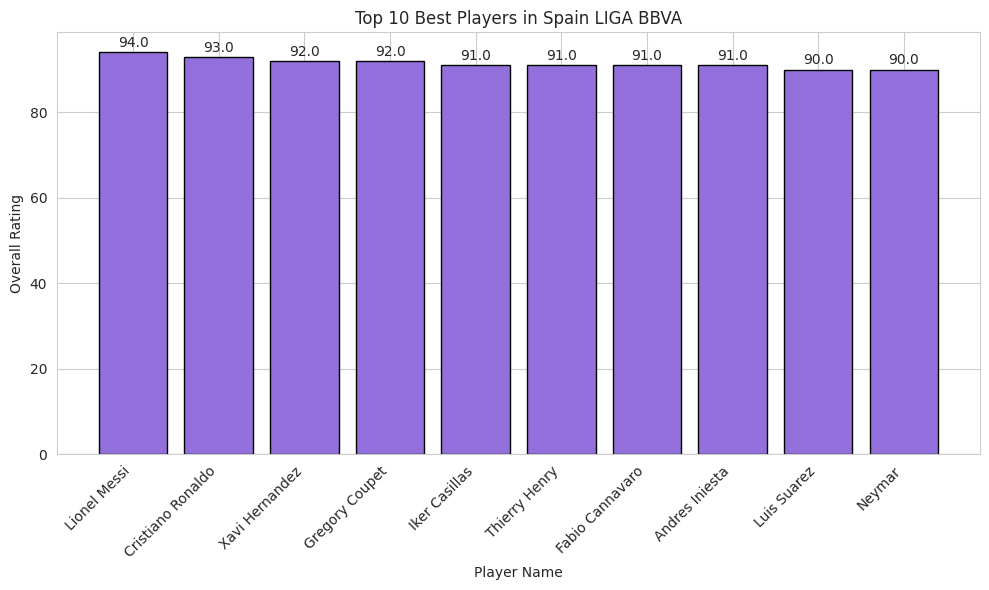

In [39]:
# 1) ฟังก์ชัน find_top_n_players_in_league
#    รับชื่อลีก (league_name) และจำนวนอันดับ n (default = 10)
def find_top_n_players_in_league(league_name, n=10):
    # 1.1) หาแถว (row) ของลีกที่ต้องการจาก df_league
    league_row = df_league[df_league['name'] == league_name]

    # ถ้าไม่มีลีกชื่อนี้ ให้แจ้งเตือนแล้ว return None
    if league_row.empty:
        print(f"ไม่พบลีก: {league_name}")
        return None

    # 1.2) ดึง country_id จากลีกนั้น ๆ
    league_country_id = league_row['country_id'].values[0]

    # 1.3) เลือกเฉพาะแมตช์ที่อยู่ในลีกนี้ (ดูจาก country_id)
    league_matches = df_match[df_match['country_id'] == league_country_id]

    # 1.4) สร้าง list ชื่อคอลัมน์ทั้งหมดที่เป็น player ใน match (home_player_1..11, away_player_1..11)
    player_cols = [f'home_player_{i}' for i in range(1, 12)] + [f'away_player_{i}' for i in range(1, 12)]

    # 1.5) ดึง player_ids (เฉพาะค่าที่ไม่เป็น NaN)
    player_ids = pd.unique(league_matches[player_cols].values.ravel('K'))
    player_ids = player_ids[~pd.isnull(player_ids)].astype(int)

    # ถ้าไม่มี player_ids เลย แปลว่าไม่พบนักเตะในแมตช์ของลีกนี้
    if len(player_ids) == 0:
        print("ไม่พบนักเตะในแมตช์ของลีกนี้")
        return None

    # 1.6) เลือกดูสถิติของนักเตะ (df_player_attr) เฉพาะคนที่อยู่ใน player_ids ข้างต้น
    df_attr_league = df_player_attr[df_player_attr['player_api_id'].isin(player_ids)]

    # ถ้าไม่มีข้อมูลสถิติของนักเตะในลีกนี้เลย
    if df_attr_league.empty:
        print("ไม่พบข้อมูลสถิติของนักเตะในลีกนี้")
        return None

    # 1.7) คำนวณค่า overall_rating สูงสุดของแต่ละ player_api_id
    #      (สมมติใช้ max() เพราะนักเตะคนเดียวอาจมี attribute หลาย record)
    df_rating = df_attr_league.groupby('player_api_id')['overall_rating'].max().reset_index()

    # 1.8) เรียงลำดับจากคะแนนสูงไปต่ำ แล้วเลือกเฉพาะ top n
    df_rating_sorted = df_rating.sort_values(by='overall_rating', ascending=False).head(n)

    # 1.9) merge กับ df_player เพื่อดึงชื่อผู้เล่น (player_name) มาประกอบ
    df_rating_sorted = df_rating_sorted.merge(
        df_player[['player_api_id', 'player_name']],
        on='player_api_id',
        how='left'
    )

    # คืน DataFrame ที่ได้
    return df_rating_sorted
# 2) เรียกใช้ฟังก์ชันเพื่อหานักเตะ Top 10 ในลีกสเปน (Spain LIGA BBVA)

top10_spain = find_top_n_players_in_league("Spain LIGA BBVA", n=10)

if top10_spain is None:
    print("ไม่พบข้อมูล Top 10 นักเตะ")
else:
    # 2.1) แสดงตารางเฉพาะคอลัมน์ player_name และ overall_rating
    print(top10_spain[['player_name', 'overall_rating']])

    # 2.2) สร้างกราฟแท่ง (Bar Chart) แสดง Top 10 นักเตะ
    plt.figure(figsize=(10, 6))
    bars = plt.bar(
        top10_spain['player_name'],
        top10_spain['overall_rating'],
        color='mediumpurple',
        edgecolor='black'
    )

    # 2.3) ใส่ตัวเลขคะแนนเหนือแท่ง
    for i, row in enumerate(top10_spain.itertuples()):
        plt.text(
            i,
            row.overall_rating + 0.5,
            f"{row.overall_rating:.1f}",
            ha='center',
            va='bottom',
            fontsize=10
        )

    # 2.4) ตั้งชื่อกราฟและแกน
    plt.title("Top 10 Best Players in Spain LIGA BBVA")
    plt.xlabel("Player Name")
    plt.ylabel("Overall Rating")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()




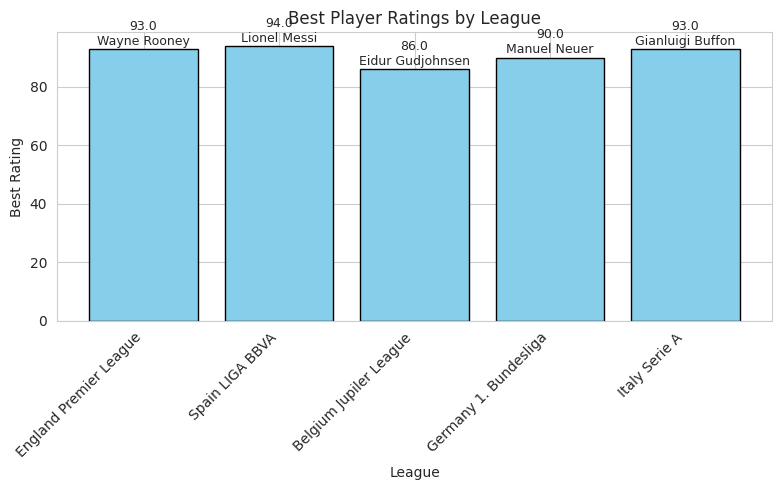

In [40]:
# รายชื่อ 5 ลีกเป้าหมาย
target_leagues = [
    "England Premier League",
    "Spain LIGA BBVA",
    "Belgium Jupiler League",
    "Germany 1. Bundesliga",
    "Italy Serie A"
]

def find_best_player_in_league(league_name):
    # หา country_id ของลีก
    league_info = df_league[df_league['name'] == league_name].iloc[0]
    country_id = league_info['country_id']

    # เลือกแมตช์ในลีกนี้
    matches = df_match[df_match['country_id'] == country_id]

    # รวม ID นักเตะจากคอลัมน์ home/away
    player_cols = [f'home_player_{i}' for i in range(1, 12)] + [f'away_player_{i}' for i in range(1, 12)]
    player_ids = pd.unique(matches[player_cols].values.ravel())
    player_ids = player_ids[~pd.isnull(player_ids)].astype(int)

    # เลือกข้อมูลสถิติของนักเตะในลีกนี้
    df_attr = df_player_attr[df_player_attr['player_api_id'].isin(player_ids)]

    # หา overall_rating สูงสุดของแต่ละนักเตะ
    df_max = df_attr.groupby('player_api_id')['overall_rating'].max().reset_index(name='max_rating')

    # เลือกคนที่มี max_rating สูงสุด
    best_row = df_max.loc[df_max['max_rating'].idxmax()]
    best_id, best_rating = best_row['player_api_id'], best_row['max_rating']

    # ดึงชื่อผู้เล่นจาก df_player
    player_name = df_player[df_player['player_api_id'] == best_id]['player_name'].values[0]
    return player_name, best_rating

# 1) วนลูปหาผู้เล่นที่ดีที่สุดในแต่ละลีก
results = []
for league in target_leagues:
    name, rating = find_best_player_in_league(league)
    results.append((league, name, rating))

# 2) สร้าง DataFrame สำหรับวาดกราฟ
df_results = pd.DataFrame(results, columns=['League', 'Player', 'Best Rating'])

# 3) วาดกราฟแท่ง
plt.figure(figsize=(8, 5))
bars = plt.bar(df_results['League'], df_results['Best Rating'], color='skyblue', edgecolor='black')

# ใส่ค่า Rating บนแท่ง
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2,
             bar.get_height() + 0.5,
             f"{df_results['Best Rating'].iloc[i]:.1f}\n{df_results['Player'].iloc[i]}",
             ha='center', va='bottom', fontsize=9)

plt.title("Best Player Ratings by League")
plt.xlabel("League")
plt.ylabel("Best Rating")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


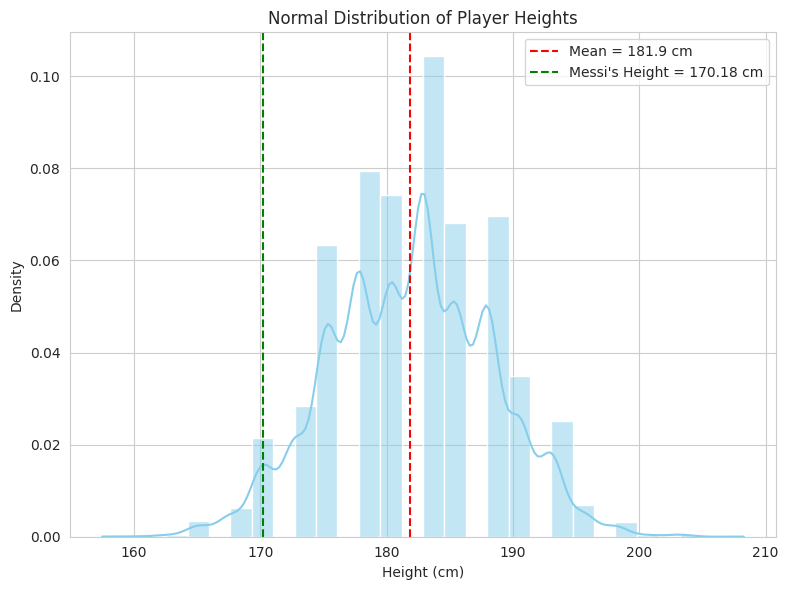

In [41]:
# เลือกเฉพาะคอลัมน์ความสูงที่ไม่ว่าง
all_heights = df_player['height'].dropna()

# หาความสูงของ Lionel Messi (ถ้ามีข้อมูล)
messi_data = df_player[df_player['player_name'] == 'Lionel Messi']
messi_height = messi_data['height'].values[0] if not messi_data.empty else None

# คำนวณค่าเฉลี่ยความสูง (mu) และส่วนเบี่ยงเบนมาตรฐาน (sigma)
mu = all_heights.mean()

# วาดกราฟ Histogram พร้อม KDE
plt.figure(figsize=(8, 6))
sns.histplot(all_heights, kde=True, color='skyblue', bins=30, stat='density')

# วาดเส้นค่าเฉลี่ย
plt.axvline(mu, color='red', linestyle='--', label=f"Mean = {mu:.1f} cm")

# วาดเส้นความสูงของ Messi (ถ้ามี)
if messi_height is not None:
    plt.axvline(messi_height, color='green', linestyle='--', label=f"Messi's Height = {messi_height} cm")

plt.title('Normal Distribution of Player Heights')
plt.xlabel('Height (cm)')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()


Top 10 นักเตะใน Spain LIGA BBVA (โดย Overall Rating สูงสุด):
         player_name  overall_rating
0       Lionel Messi            94.0
1  Cristiano Ronaldo            93.0
2     Xavi Hernandez            92.0
3     Gregory Coupet            92.0
4      Iker Casillas            91.0
5      Thierry Henry            91.0
6    Fabio Cannavaro            91.0
7     Andres Iniesta            91.0
8        Luis Suarez            90.0
9             Neymar            90.0

Top 10 นักเตะพร้อม win rate:
         player_name  overall_rating  win_rate  matches_played
0       Lionel Messi            94.0  0.779116             249
1  Cristiano Ronaldo            93.0  0.767544             228
2     Xavi Hernandez            92.0  0.761905             189
3     Gregory Coupet            92.0  0.333333               6
4      Iker Casillas            91.0  0.745000             200
5      Thierry Henry            91.0  0.897436              39
6    Fabio Cannavaro            91.0  0.655172              2

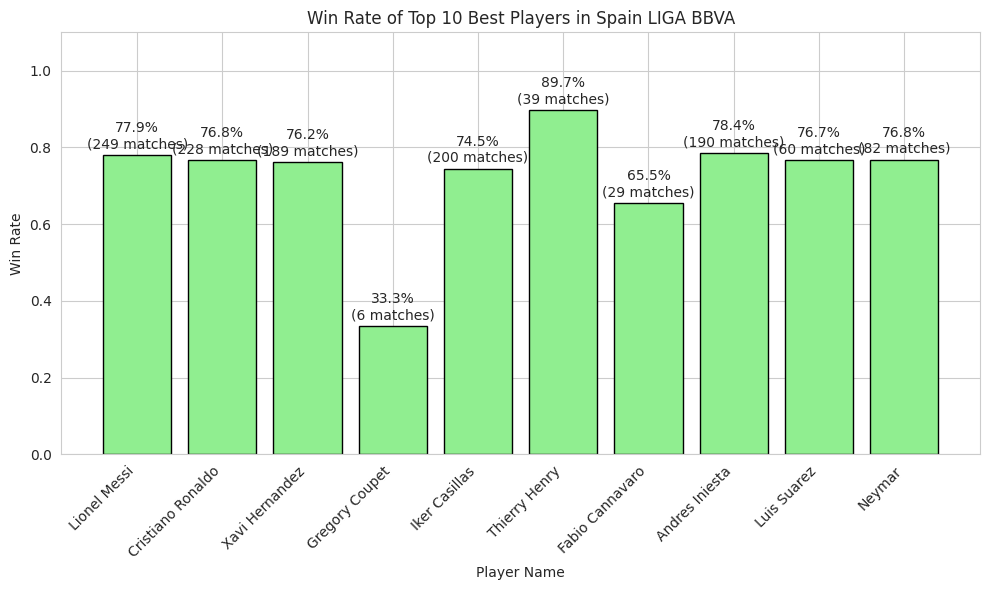

In [42]:
def find_top_n_players_in_league(league_name, n=10):
    # ค้นหาข้อมูลลีกตามชื่อที่ระบุ
    league_row = df_league[df_league['name'] == league_name]
    if league_row.empty:
        print(f"ไม่พบลีก: {league_name}")
        return None
    # ดึง country_id ของลีกนั้น แล้วเลือกแมตช์ที่ตรงกัน
    country_id = league_row['country_id'].values[0]
    league_matches = df_match[df_match['country_id'] == country_id]

    # ดึง player_id จากทั้งคอลัมน์ home และ away
    player_cols = [f'home_player_{i}' for i in range(1, 12)] + [f'away_player_{i}' for i in range(1, 12)]
    player_ids = pd.unique(league_matches[player_cols].values.ravel())
    player_ids = player_ids[~pd.isnull(player_ids)].astype(int)
    if len(player_ids) == 0:
        print("ไม่พบนักเตะในแมตช์ของลีกนี้")
        return None

    # เลือกข้อมูลสถิติของนักเตะที่ลงเล่นในลีกนี้
    df_attr_league = df_player_attr[df_player_attr['player_api_id'].isin(player_ids)]
    if df_attr_league.empty:
        print("ไม่พบข้อมูลสถิติของนักเตะในลีกนี้")
        return None

    # หาค่าสูงสุดของ overall_rating ของแต่ละนักเตะ
    df_rating = df_attr_league.groupby('player_api_id')['overall_rating'].max().reset_index()
    top_players = df_rating.sort_values(by='overall_rating', ascending=False).head(n)
    # ผสานกับตาราง Player เพื่อดึงชื่อผู้เล่น
    top_players = top_players.merge(df_player[['player_api_id', 'player_name']], on='player_api_id', how='left')
    return top_players, country_id, league_matches

# ค้นหา Top 10 นักเตะใน "Spain LIGA BBVA"
top10_spain, spain_country_id, spanish_matches = find_top_n_players_in_league("Spain LIGA BBVA", n=10)
if top10_spain is None:
    print("ไม่พบข้อมูล Top 10 นักเตะ")
else:
    print("Top 10 นักเตะใน Spain LIGA BBVA (โดย Overall Rating สูงสุด):")
    print(top10_spain[['player_name', 'overall_rating']])

def get_player_win_rate(player_id, matches_df):
    # เลือกแมตช์ที่นักเตะปรากฏในตำแหน่ง home หรือ away
    cols = [f'home_player_{i}' for i in range(1, 12)] + [f'away_player_{i}' for i in range(1, 12)]
    mask = matches_df[cols].isin([player_id]).any(axis=1)
    player_matches = matches_df[mask]
    if player_matches.empty:
        return 0, 0
    wins = 0
    # นับจำนวนชัยชนะของนักเตะในแมตช์ที่ลงเล่น
    for _, row in player_matches.iterrows():
        home_players = row[[f'home_player_{i}' for i in range(1, 12)]].values
        away_players = row[[f'away_player_{i}' for i in range(1, 12)]].values
        if player_id in home_players and row['home_team_goal'] > row['away_team_goal']:
            wins += 1
        elif player_id in away_players and row['away_team_goal'] > row['home_team_goal']:
            wins += 1
    win_rate = wins / len(player_matches)
    return win_rate, len(player_matches)

# คำนวณ win rate และจำนวนแมตช์ที่ลงเล่นสำหรับแต่ละนักเตะใน Top 10
win_rates = []
matches_played = []
for pid in top10_spain['player_api_id']:
    wr, mp = get_player_win_rate(pid, spanish_matches)
    win_rates.append(wr)
    matches_played.append(mp)

top10_spain['win_rate'] = win_rates
top10_spain['matches_played'] = matches_played

print("\nTop 10 นักเตะพร้อม win rate:")
print(top10_spain[['player_name', 'overall_rating', 'win_rate', 'matches_played']])

# วาดกราฟแท่งแสดง win rate ของ Top 10
plt.figure(figsize=(10, 6))
bars = plt.bar(top10_spain['player_name'], top10_spain['win_rate'], color='lightgreen', edgecolor='black')
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01,
             f"{top10_spain['win_rate'].iloc[i]*100:.1f}%\n({top10_spain['matches_played'].iloc[i]} matches)",
             ha='center', va='bottom', fontsize=10)

plt.title("Win Rate of Top 10 Best Players in Spain LIGA BBVA")
plt.xlabel("Player Name")
plt.ylabel("Win Rate")
plt.ylim(0, 1.1)  # กำหนดแกน y จาก 0 ถึง 1.1 เพื่อรองรับ label
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



Messi ID: 30981
จำนวนแมตช์ที่ Messi ลงเล่น: 249
ค่าเฉลี่ย rating ของ Messi ตามผลการแข่งขัน:
 messi_result
Draw    92.424242
Loss    92.772727
Win     92.381443
Name: overall_rating, dtype: float64


<ipython-input-44-41224ec7ae0d>:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=messi_matches_merged, x='messi_result', y='overall_rating', palette='pastel')


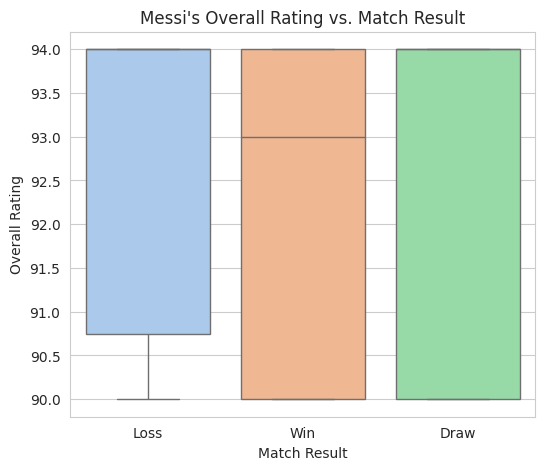

In [44]:
# 1. หา player_api_id ของ Lionel Messi
messi_row = df_player[df_player['player_name'] == 'Lionel Messi']
if messi_row.empty:
    raise ValueError("ไม่พบ Lionel Messi ในตาราง Player")
messi_id = messi_row.iloc[0]['player_api_id']
print("Messi ID:", messi_id)

# 2. กรองแมตช์ที่ Messi ลงสนาม (ทั้งเจ้าบ้านและทีมเยือน)
player_cols = [f'home_player_{i}' for i in range(1, 12)] + [f'away_player_{i}' for i in range(1, 12)]
mask = df_match[player_cols].isin([messi_id]).any(axis=1)
messi_matches = df_match[mask].copy()
print("จำนวนแมตช์ที่ Messi ลงเล่น:", len(messi_matches))

# 3. กำหนดผลการแข่งขัน (Win/Draw/Loss) ของทีมที่ Messi ลงเล่น
def get_messi_result(row, messi_id):
    home_players = row[[f'home_player_{i}' for i in range(1, 12)]].values
    away_players = row[[f'away_player_{i}' for i in range(1, 12)]].values
    if messi_id in home_players:
        if row['home_team_goal'] > row['away_team_goal']:
            return 'Win'
        elif row['home_team_goal'] == row['away_team_goal']:
            return 'Draw'
        else:
            return 'Loss'
    else:
        if row['away_team_goal'] > row['home_team_goal']:
            return 'Win'
        elif row['away_team_goal'] == row['home_team_goal']:
            return 'Draw'
        else:
            return 'Loss'

messi_matches['messi_result'] = messi_matches.apply(lambda r: get_messi_result(r, messi_id), axis=1)

# 4. เตรียมข้อมูล rating ของ Messi จาก Player_Attributes
df_messi_attr = df_player_attr[df_player_attr['player_api_id'] == messi_id].copy()
df_messi_attr['date'] = pd.to_datetime(df_messi_attr['date'])
df_messi_attr.sort_values(by='date', inplace=True)

# 5. แปลงวันที่ของแมตช์ และจับคู่ rating ที่ใกล้เคียง (ไม่เกินวันที่แข่ง)
messi_matches['match_date'] = pd.to_datetime(messi_matches['date'])
messi_matches.sort_values(by='match_date', inplace=True)

messi_matches_merged = pd.merge_asof(
    messi_matches,
    df_messi_attr[['date', 'overall_rating']].rename(columns={'date': 'attr_date'}),
    left_on='match_date',
    right_on='attr_date',
    direction='backward'
)

# 6. สรุปผล: ค่าเฉลี่ย rating แยกตามผลการแข่งขัน
result_summary = messi_matches_merged.groupby('messi_result')['overall_rating'].mean()
print("ค่าเฉลี่ย rating ของ Messi ตามผลการแข่งขัน:\n", result_summary)

# 7. วาด Boxplot แสดง rating ของ Messi ตามผลการแข่งขัน
sns.set_style('whitegrid')
plt.figure(figsize=(6, 5))
sns.boxplot(data=messi_matches_merged, x='messi_result', y='overall_rating', palette='pastel')
plt.title("Messi's Overall Rating vs. Match Result")
plt.xlabel("Match Result")
plt.ylabel("Overall Rating")
plt.show()


**Part 2**

In [45]:
def get_winner(row):
    if row['home_team_goal'] > row['away_team_goal']:
        return row['home_team_api_id']
    elif row['away_team_goal'] > row['home_team_goal']:
        return row['away_team_api_id']
    else:
        return None

df_match['winner_id'] = df_match.apply(get_winner, axis=1)

win_count = df_match['winner_id'].value_counts().reset_index()
win_count.columns = ['team_api_id', 'wins']

win_count = win_count.merge(df_team[['team_api_id', 'team_long_name']], on='team_api_id', how='left')

win_count_sorted = win_count.sort_values(by='wins', ascending=False)
top_5 = win_count_sorted.head(5)

print("5 ทีมที่ชนะบ่อยที่สุด (เรียงจากมากไปน้อย):")
print(top_5[['team_long_name', 'wins']].to_string(index=False))

5 ทีมที่ชนะบ่อยที่สุด (เรียงจากมากไปน้อย):
   team_long_name  wins
     FC Barcelona   234
   Real Madrid CF   228
           Celtic   218
 FC Bayern Munich   193
Manchester United   192


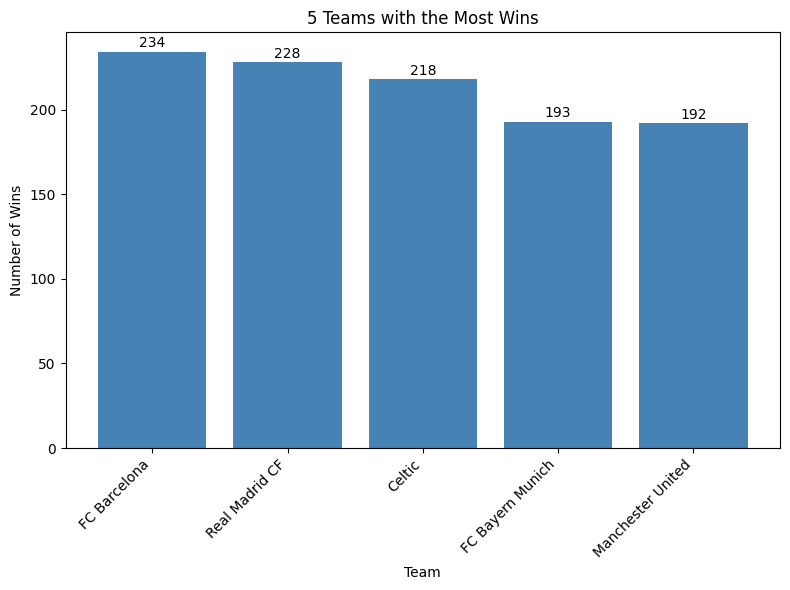

In [ ]:
data = {
    'team_long_name': [
        'FC Barcelona',
        'Real Madrid CF',
        'Celtic',
        'FC Bayern Munich',
        'Manchester United'
    ],
    'wins': [234, 228, 218, 193, 192]
}

df_top5 = pd.DataFrame(data)

plt.figure(figsize=(8, 6))

bars = plt.bar(df_top5['team_long_name'], df_top5['wins'], color='steelblue')

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 1,
        f'{height}',
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.title('5 Teams with the Most Wins')
plt.xlabel('Team')
plt.ylabel('Number of Wins')

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

       season   team_long_name  total_points  rank
2   2008/2009     FC Barcelona            87   1.0
1   2008/2009   Real Madrid CF            78   2.0
0   2008/2009       Sevilla FC            70   3.0
4   2009/2010     FC Barcelona            99   1.0
3   2009/2010   Real Madrid CF            96   2.0
5   2009/2010      Valencia CF            71   3.0
7   2010/2011     FC Barcelona            96   1.0
6   2010/2011   Real Madrid CF            92   2.0
8   2010/2011      Valencia CF            71   3.0
9   2011/2012   Real Madrid CF           100   1.0
10  2011/2012     FC Barcelona            91   2.0
11  2011/2012      Valencia CF            61   3.0
13  2012/2013     FC Barcelona           100   1.0
12  2012/2013   Real Madrid CF            85   2.0
14  2012/2013  Atlético Madrid            76   3.0
17  2013/2014  Atlético Madrid            90   1.0
15  2013/2014   Real Madrid CF            87   2.0
16  2013/2014     FC Barcelona            87   3.0
19  2014/2015     FC Barcelona 

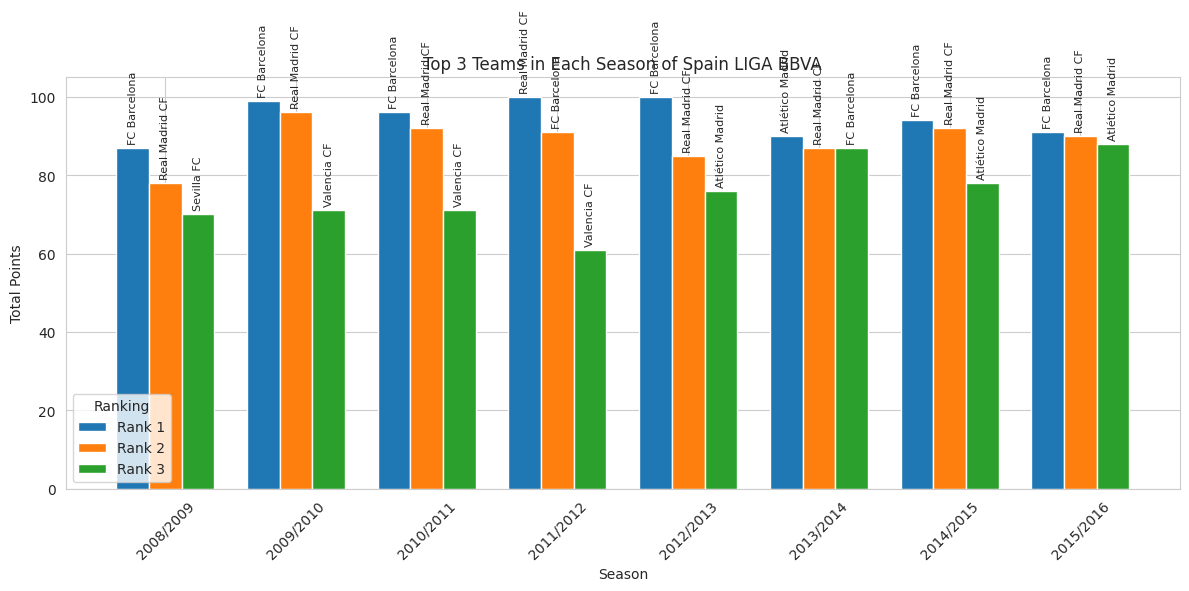

In [46]:
# เลือกข้อมูลลีก Spain LIGA BBVA
spain_league_id = df_league[df_league['name'] == "Spain LIGA BBVA"].iloc[0]['id']

# เลือกแมตช์ในลีก Spain
df_spain = df_match[df_match['league_id'] == spain_league_id].copy()

# คำนวณคะแนน: ชนะ = 3, เสมอ = 1, แพ้ = 0
df_spain['home_points'] = df_spain.apply(
    lambda row: 3 if row['home_team_goal'] > row['away_team_goal'] else (1 if row['home_team_goal'] == row['away_team_goal'] else 0),
    axis=1
)
df_spain['away_points'] = df_spain.apply(
    lambda row: 3 if row['away_team_goal'] > row['home_team_goal'] else (1 if row['away_team_goal'] == row['home_team_goal'] else 0),
    axis=1
)

# รวมคะแนนจากแมตช์เจ้าบ้านและเยือนในแต่ละฤดูกาล
home_points = df_spain.groupby(['season', 'home_team_api_id'])['home_points'].sum().reset_index()
home_points.rename(columns={'home_team_api_id': 'team_api_id'}, inplace=True)
away_points = df_spain.groupby(['season', 'away_team_api_id'])['away_points'].sum().reset_index()
away_points.rename(columns={'away_team_api_id': 'team_api_id'}, inplace=True)

df_points = pd.merge(home_points, away_points, on=['season', 'team_api_id'], how='outer').fillna(0)
df_points['total_points'] = df_points['home_points'] + df_points['away_points']

# คำนวณอันดับในแต่ละฤดูกาล (อันดับ 1 = คะแนนสูงสุด)
df_points['rank'] = df_points.groupby('season')['total_points'].rank(method='first', ascending=False)
df_top3 = df_points[df_points['rank'] <= 3].copy()

# ผสานกับข้อมูลทีมเพื่อดึงชื่อทีม
df_top3 = pd.merge(df_top3, df_team[['team_api_id', 'team_long_name']], on='team_api_id', how='left')
df_top3.sort_values(['season', 'rank'], inplace=True)
print(df_top3[['season', 'team_long_name', 'total_points', 'rank']])

# วาดกราฟแท่งแสดง Top 3 ทีมในแต่ละฤดูกาล
seasons = df_top3['season'].unique()
x_positions = np.arange(len(seasons))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))
for i, r in enumerate([1, 2, 3]):
    df_rank = df_top3[df_top3['rank'] == r].set_index('season').reindex(seasons).reset_index()
    ax.bar(x_positions + i * width, df_rank['total_points'], width=width, label=f"Rank {int(r)}")
    for j, row in df_rank.iterrows():
        if pd.notna(row['total_points']):
            ax.text(x_positions[j] + i * width, row['total_points'] + 1,
                    row['team_long_name'], ha='center', va='bottom', fontsize=8, rotation=90)

ax.set_xticks(x_positions + width)
ax.set_xticklabels(seasons, rotation=45)
ax.set_xlabel("Season")
ax.set_ylabel("Total Points")
ax.set_title("Top 3 Teams in Each Season of Spain LIGA BBVA")
ax.legend(title="Ranking")
plt.tight_layout()
plt.show()





Coefficient (slope): -0.17857142857142866
Intercept: 452.3214285714287


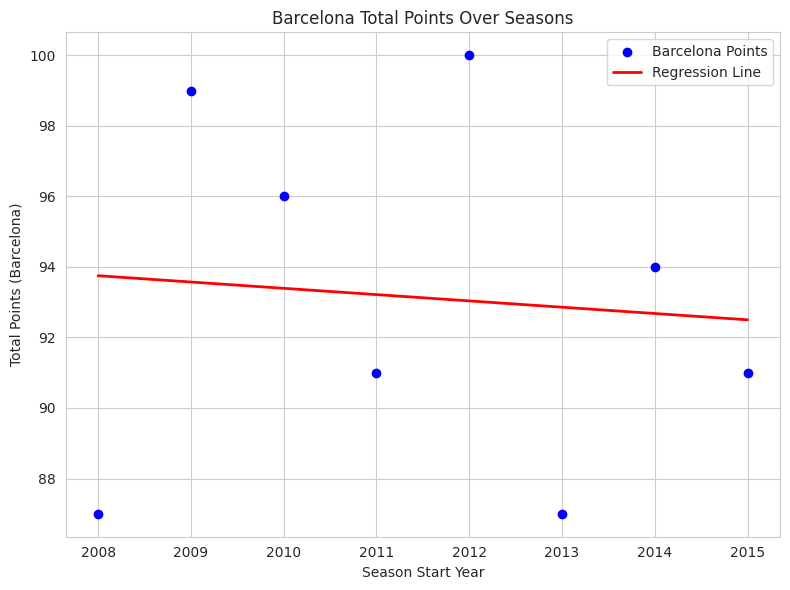

In [47]:
# เลือกลีก Spain LIGA BBVA
df_spain_league = df_league[df_league['name'] == "Spain LIGA BBVA"]
if df_spain_league.empty:
    raise ValueError("ไม่พบข้อมูลลีก Spain LIGA BBVA")
spain_league_id = df_spain_league.iloc[0]['id']

# เลือกแมตช์ในลีก Spain
df_spain = df_match[df_match['league_id'] == spain_league_id].copy()

# คำนวณคะแนน: 3 คะแนนถ้าชนะ, 1 คะแนนถ้าเสมอ, 0 คะแนนถ้าแพ้
df_spain['home_points'] = df_spain.apply(
    lambda row: 3 if row['home_team_goal'] > row['away_team_goal']
    else (1 if row['home_team_goal'] == row['away_team_goal'] else 0), axis=1)
df_spain['away_points'] = df_spain.apply(
    lambda row: 3 if row['away_team_goal'] > row['home_team_goal']
    else (1 if row['away_team_goal'] == row['home_team_goal'] else 0), axis=1)

# รวมคะแนนจากแมตช์เจ้าบ้านและเยือน
home_points = df_spain.groupby(['season', 'home_team_api_id'])['home_points'].sum().reset_index()
home_points.rename(columns={'home_team_api_id': 'team_api_id'}, inplace=True)
away_points = df_spain.groupby(['season', 'away_team_api_id'])['away_points'].sum().reset_index()
away_points.rename(columns={'away_team_api_id': 'team_api_id'}, inplace=True)

df_points = pd.merge(home_points, away_points, on=['season', 'team_api_id'], how='outer').fillna(0)
df_points['total_points'] = df_points['home_points'] + df_points['away_points']

# เลือกทีม FC Barcelona
barca_id = df_team[df_team['team_long_name'] == 'FC Barcelona'].iloc[0]['team_api_id']
df_barca = df_points[df_points['team_api_id'] == barca_id].copy()

# แปลง season (เช่น "2015/2016") เป็นปีเริ่มต้น (2015)
df_barca['start_year'] = df_barca['season'].apply(lambda s: int(s.split('/')[0]))

# เตรียมข้อมูลสำหรับ Linear Regression
X = df_barca[['start_year']]
y = df_barca['total_points']

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

print("Coefficient (slope):", model.coef_[0])
print("Intercept:", model.intercept_)

# วาดกราฟ Scatter และเส้น Regression
plt.figure(figsize=(8, 6))
plt.scatter(df_barca['start_year'], df_barca['total_points'], color='blue', label='Barcelona Points')
plt.plot(df_barca['start_year'], y_pred, color='red', linewidth=2, label='Regression Line')
plt.xlabel("Season Start Year")
plt.ylabel("Total Points (Barcelona)")
plt.title("Barcelona Total Points Over Seasons")
plt.legend()
plt.tight_layout()
plt.show()



In [48]:
# รายการลีกเป้าหมาย
target_leagues = [
    "England Premier League",
    "Spain LIGA BBVA",
    "Belgium Jupiler League",
    "Germany 1. Bundesliga",
    "Italy Serie A"
]

def find_best_player_in_league(league_name):
    # 1. หาแถวของลีกตามชื่อที่ระบุ
    row = df_league[df_league['name'] == league_name]
    if row.empty:
        return None, None
    league_country_id = row['country_id'].values[0]

    # 2. เลือกแมตช์ในลีกนี้โดยใช้ country_id
    league_matches = df_match[df_match['country_id'] == league_country_id]

    # 3. ดึงรายชื่อนักเตะจากคอลัมน์ home และ away
    player_cols = [f'home_player_{i}' for i in range(1, 12)] + [f'away_player_{i}' for i in range(1, 12)]
    league_player_ids = pd.unique(league_matches[player_cols].values.ravel('K'))
    league_player_ids = league_player_ids[~pd.isnull(league_player_ids)].astype(int)
    if len(league_player_ids) == 0:
        return None, None

    # 4. เลือกข้อมูลสถิติของนักเตะในลีกนี้
    df_attr_league = df_player_attr[df_player_attr['player_api_id'].isin(league_player_ids)]
    if df_attr_league.empty:
        return None, None

    # 5. หาค่า overall_rating สูงสุดของแต่ละนักเตะ
    df_max_rating = df_attr_league.groupby('player_api_id')['overall_rating'] \
                                 .max() \
                                 .reset_index(name='max_rating')
    # 6. เลือกนักเตะที่มีคะแนนสูงสุดในลีกนี้
    best_row = df_max_rating.loc[df_max_rating['max_rating'].idxmax()]
    best_player_id = best_row['player_api_id']
    best_rating = best_row['max_rating']

    # 7. ดึงชื่อของนักเตะจากตาราง Player
    row_player = df_player[df_player['player_api_id'] == best_player_id]
    best_player_name = row_player['player_name'].values[0] if not row_player.empty else str(best_player_id)

    return best_player_name, best_rating

# วนลูปสำหรับทุกลีกใน target_leagues และเก็บผลลัพธ์
results = []
for league in target_leagues:
    player_name, rating = find_best_player_in_league(league)
    results.append({
        'league': league,
        'best_player': player_name if player_name else 'Not found',
        'best_rating': rating if rating else 'N/A'
    })

# สร้าง DataFrame สรุปผลและแสดงผล
df_results = pd.DataFrame(results)
print(df_results)


                   league       best_player  best_rating
0  England Premier League      Wayne Rooney         93.0
1         Spain LIGA BBVA      Lionel Messi         94.0
2  Belgium Jupiler League  Eidur Gudjohnsen         86.0
3   Germany 1. Bundesliga      Manuel Neuer         90.0
4           Italy Serie A  Gianluigi Buffon         93.0


Correlation (Speed vs. Total Goals) = 0.019
Correlation (Passing vs. Total Goals) = 0.310


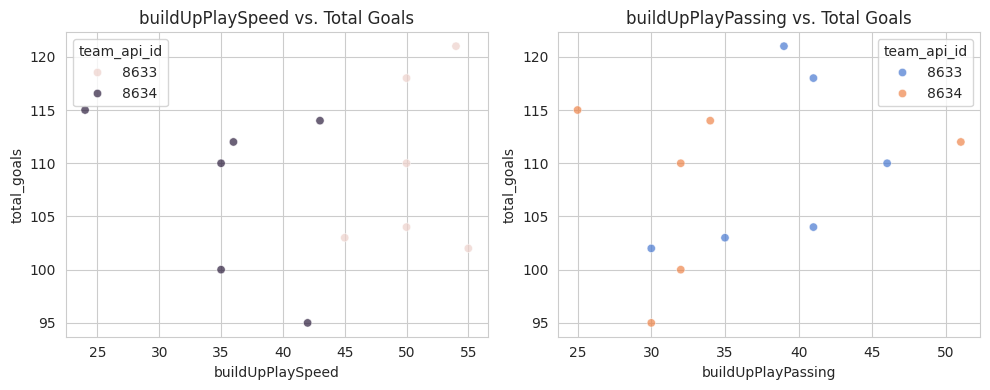

       season  team_api_id  total_goals  buildUpPlaySpeed  buildUpPlayPassing
0   2010/2011         8633          102                55                  30
1   2010/2011         8634           95                42                  30
2   2011/2012         8633          121                54                  39
3   2011/2012         8634          114                43                  34
4   2012/2013         8633          103                45                  35
5   2012/2013         8634          115                24                  25
6   2013/2014         8633          104                50                  41
7   2013/2014         8634          100                35                  32
8   2014/2015         8633          118                50                  41
9   2014/2015         8634          110                35                  32
10  2015/2016         8633          110                50                  46
11  2015/2016         8634          112                36       

In [50]:
# 1. หารหัสทีมของ FC Barcelona และ Real Madrid CF
barca_id = df_team[df_team['team_long_name'] == 'FC Barcelona'].iloc[0]['team_api_id']
madrid_id = df_team[df_team['team_long_name'] == 'Real Madrid CF'].iloc[0]['team_api_id']
team_ids = [barca_id, madrid_id]

# 2. รวมผลรวมประตูที่ทำได้ในแต่ละฤดูกาล (ทั้งเจ้าบ้านและเยือน)
home_goals = df_match.groupby(['season', 'home_team_api_id'])['home_team_goal'].sum().reset_index()
home_goals.rename(columns={'home_team_api_id': 'team_api_id', 'home_team_goal': 'goals_scored'}, inplace=True)

away_goals = df_match.groupby(['season', 'away_team_api_id'])['away_team_goal'].sum().reset_index()
away_goals.rename(columns={'away_team_api_id': 'team_api_id', 'away_team_goal': 'goals_scored'}, inplace=True)

df_goals = pd.concat([home_goals, away_goals], ignore_index=True)
df_goals = df_goals.groupby(['season', 'team_api_id'])['goals_scored'].sum().reset_index()
df_goals.rename(columns={'goals_scored': 'total_goals'}, inplace=True)
df_goals = df_goals[df_goals['team_api_id'].isin(team_ids)]

# 3. เตรียมข้อมูลทีม Attributes โดยแปลงวันที่และเลือกค่าล่าสุดของแต่ละปี
df_team_attr['date'] = pd.to_datetime(df_team_attr['date'])
df_team_attr['year'] = df_team_attr['date'].dt.year
# ดึงปีเริ่มต้นจาก string ของ season (เช่น "2015/2016" -> 2015)
df_goals['start_year'] = df_goals['season'].apply(lambda s: int(s.split('/')[0]))

cols = ['team_api_id', 'date', 'year', 'buildUpPlaySpeed', 'buildUpPlayPassing']
df_team_attr_filtered = df_team_attr[cols]
df_team_attr_filtered = df_team_attr_filtered[df_team_attr_filtered['team_api_id'].isin(team_ids)]
df_team_attr_filtered.sort_values(by=['team_api_id', 'year', 'date'], inplace=True)
df_team_attr_filtered = df_team_attr_filtered.groupby(['team_api_id', 'year']).last().reset_index()

# 4. Merge ข้อมูลเป้าหมาย (total_goals) กับ team attributes โดยจับคู่ปีที่ตรงกัน
df_merged = pd.merge(df_goals, df_team_attr_filtered,
                     left_on=['team_api_id', 'start_year'],
                     right_on=['team_api_id', 'year'],
                     how='inner')

# 5. คำนวณสหสัมพันธ์ระหว่าง buildUpPlaySpeed/Passing กับ total_goals
corr_speed = df_merged[['buildUpPlaySpeed', 'total_goals']].corr().iloc[0, 1]
corr_pass  = df_merged[['buildUpPlayPassing', 'total_goals']].corr().iloc[0, 1]

print(f"Correlation (Speed vs. Total Goals) = {corr_speed:.3f}")
print(f"Correlation (Passing vs. Total Goals) = {corr_pass:.3f}")

# 6. วาดกราฟ Scatter Plot
sns.set_style('whitegrid')
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.scatterplot(data=df_merged, x='buildUpPlaySpeed', y='total_goals', hue='team_api_id', alpha=0.7)
plt.title("buildUpPlaySpeed vs. Total Goals")

plt.subplot(1, 2, 2)
sns.scatterplot(data=df_merged, x='buildUpPlayPassing', y='total_goals', hue='team_api_id', alpha=0.7, palette='muted')
plt.title("buildUpPlayPassing vs. Total Goals")

plt.tight_layout()
plt.show()

# แสดงตารางข้อมูลสำคัญ
print(df_merged[['season', 'team_api_id', 'total_goals', 'buildUpPlaySpeed', 'buildUpPlayPassing']])




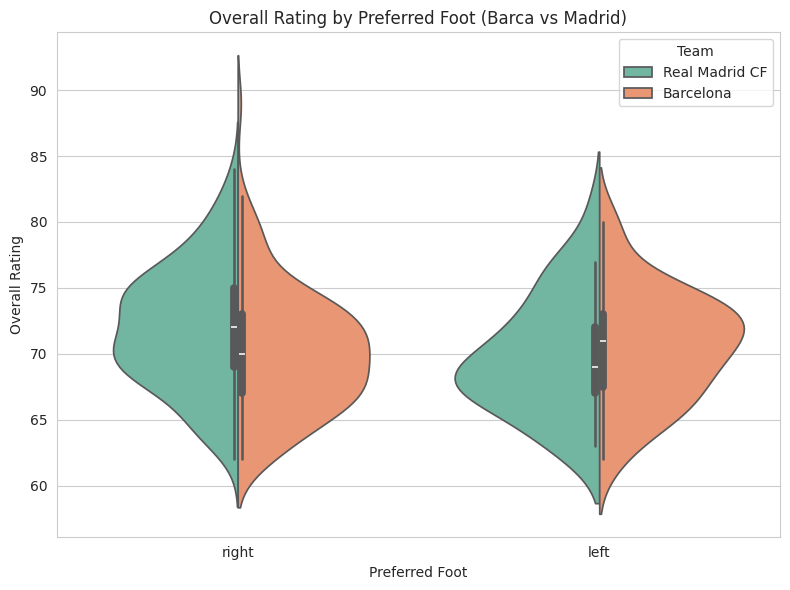

team            preferred_foot
Barcelona       left               35
                right             117
Real Madrid CF  left               36
                right             111
Name: player_id, dtype: int64


In [51]:
# 1. หารหัสทีม
barca_id = df_team[df_team['team_long_name'] == 'FC Barcelona'].iloc[0]['team_api_id']
madrid_id = df_team[df_team['team_long_name'] == 'Real Madrid CF'].iloc[0]['team_api_id']

# 2. กำหนดคอลัมน์นักเตะ
home_cols = [f'home_player_{i}' for i in range(1, 12)]
away_cols = [f'away_player_{i}' for i in range(1, 12)]
player_cols = home_cols + away_cols

# 3. ฟังก์ชันดึงนักเตะในทีม
def get_players_for_team(df, team_id):
    df_team_matches = df[(df['home_team_api_id'] == team_id) | (df['away_team_api_id'] == team_id)]
    players = pd.unique(df_team_matches[player_cols].values.ravel())
    return set(players[~pd.isnull(players)].astype(int))

barca_players = get_players_for_team(df_match, barca_id)
madrid_players = get_players_for_team(df_match, madrid_id)

# 4. สร้าง mapping ระบุว่าผู้เล่นอยู่ในทีมใด (skip ถ้าลงเล่นให้ทั้งสองทีม)
player_team_map = {}
for pid in barca_players:
    player_team_map[pid] = 'Barcelona'
for pid in madrid_players:
    if pid in player_team_map:
        player_team_map[pid] = 'Both'
    else:
        player_team_map[pid] = 'Real Madrid CF'

# 5. ดึงข้อมูลสถิติล่าสุดของนักเตะแต่ละคน
df_player_attr.sort_values(by=['player_api_id', 'date'], inplace=True)
df_latest = df_player_attr.groupby('player_api_id').last().reset_index()

# 6. สร้าง DataFrame สำหรับ plot โดยเลือกเฉพาะนักเตะที่ไม่ได้ลงเล่นให้ทั้งสองทีม
data = []
for _, row in df_latest.iterrows():
    pid = row['player_api_id']
    if pid in player_team_map and player_team_map[pid] != 'Both':
        data.append((pid, player_team_map[pid], row['preferred_foot'], row['overall_rating']))
df_plot = pd.DataFrame(data, columns=['player_id', 'team', 'preferred_foot', 'overall_rating'])

# 7. วาด Violin Plot
plt.figure(figsize=(8,6))
sns.set_style('whitegrid')
sns.violinplot(data=df_plot, x='preferred_foot', y='overall_rating', hue='team', split=True, palette='Set2')
plt.title("Overall Rating by Preferred Foot (Barca vs Madrid)")
plt.xlabel("Preferred Foot")
plt.ylabel("Overall Rating")
plt.legend(title="Team")
plt.tight_layout()
plt.show()

# แสดงจำนวนผู้เล่นในแต่ละกลุ่ม
print(df_plot.groupby(['team', 'preferred_foot'])['player_id'].count())

